In [1]:
from itertools import groupby
import pandas as pd
import numpy as np

%config Completer.use_jedi = False

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def load_df_dhs(filename='KEIR71FL.DTA'):
    """
    load dhs data, make sure that calendar data is available
    in the file and remove rows that don't contain calendar data.
    """
    dhs = pd.read_stata(filename, convert_categoricals=False)
    assert 'vcal_1' in dhs.columns
    dhs = dhs[dhs.vcal_1 != '']
    
    return dhs

def get_clean_calender(dhs):
    """
    clean up the calender data by replacing episodes with no event
    with 0 and align discontinuation data with contraceptive use data
    """
    dhs_calendar = pd.DataFrame(columns=['vcal_1', 'vcal_2'])
    for w in dhs.index:      
        cero = list(dhs['vcal_1'][w])
        disc = list(dhs['vcal_2'][w].ljust(80))

        cs = []
        ds = []
        for c, d in zip(cero, disc):
            if d == ' ':
                d = '0'
            cs.append(c)
            ds.append(d)
          
        row = pd.Series({'vcal_1': ''.join(cs), 'vcal_2': ''.join(ds)}, name=w)
        dhs_calendar = dhs_calendar.append(row, ignore_index=False)

    return dhs_calendar

def sideeffect_method(row_arg):
    
    vcal_1 = row_arg['vcal_1']
    vcal_2 = row_arg['vcal_2'][-len(vcal_1.strip()):]

    l = list(vcal_1.strip()[:60])
    d = list(vcal_2.strip()[:60])
    
    methods = []
    for ind, m in enumerate(d):
        if m == '4':
            methods.append(l[ind])
    
    return methods

def methods(row_arg):
    
    vcal_1 = row_arg['vcal_1'].strip()
    vcal_1 = vcal_1.replace("0", "").replace("P", "").replace("T", "").replace("B", "")
    
    return list(vcal_1)
    
    
def pre(d, l, ix=60, TG=True):
    """
    Find the first use of either injectables or one of (Pills, Implant, EC, or IUD).
    If none of these methods are present, then return None.
    T =1 corresponds to first use of injectables, otherwise, T=0. Also return the
    corresponding month as the index date.
    """
    
    inj_index = 0
    other_index = 0
    
    if '3' in l:
        inj_index = ix - l[::-1].index('3')
                
    other_index = ix - min([l[::-1].index(i) if i in l else ix for i in ['1', '2', 'N', 'E']])
    
    if TG: 
        if inj_index > 0:
            t = 1; ind = inj_index;
        else:
            return
    else:
        if other_index > 0:
            t = 0; ind = other_index;
        else:
            return     
    
    return t, ind
    

def nmonth_discontinuation(row_arg, TG=True):
    """
        for each record's (calendar data). We assume there is at least 60 months of 
        method use and discontinuation data. Classify each record into treated or control;
        based on the method that is first used and 3 months of method-naivety.
        Determine 12 month discontinuation from index date. If there are less than 12 months
        from index date, then return NaN as the outcome.
        
    """
    
    vcal_1 = row_arg['vcal_1']
    vcal_2 = row_arg['vcal_2'][-len(vcal_1.strip()):]

    l = list(vcal_1.strip()[:60])
    d = list(vcal_2.strip()[:60])
    
    if pre(d, l, 60, TG):
        t, ind = pre(d, l, 60, TG)
    else:
        return
    
    A = ['0', 'P', 'T', 'B']
    for a in vcal_1.strip()[ind: ind + 3]:
        if a not in A:
            
            l = list(vcal_1.strip()[:ind])
            d = list(vcal_2.strip()[:ind])
            
            if pre(d, l, ind, TG):
                t, ind = pre(d, l, ind, TG)
                for a in vcal_1.strip()[ind: ind + 3]:
                    if a not in A:
                        return
            else:
                return
    
    if len(d[:ind]) < 12:
        o = float('nan')
        return t,o
    else:
        
        nmonth_window = d[:ind][-12:]
        assert len(nmonth_window) == 12
        if '4' not in nmonth_window:
            o = 0
        else:
            disc_ind = nmonth_window[::-1].index('4')
            method = l[:ind][-12:][::-1][disc_ind]
            
            if method == l[ind-1]:
                o = 1
            else:
                o = 0
        return t,o
    
def plot_distr(calender_data, ctry):
    
    s = calender_data.apply(methods, axis=1)
    m = [element for list_ in s for element in list_]

    counts = np.unique(m, return_counts=True)[1]
    unique = np.unique(m, return_counts=True)[0]
    ratio = counts/counts.sum()

    x = list(map(lambda x: x, unique[np.argsort(ratio)][::-1]))
    y = np.sort(ratio)[::-1]

    fig, ax = plt.subplots(1)

    ax.barh(x, y)
    plt.xticks(rotation='horizontal')
    plt.tight_layout()
    fig.savefig('figures/'+ ctry + '-distr.pdf')
    


def nmonth_discontinuation_multiple(df):
    
    t1 = df.apply(nmonth_discontinuation, axis=1)
    t1 = t1[t1.notna()]
    t0 = df.apply(nmonth_discontinuation, TG=False, axis=1)
    t0 = t0[t0.notna()]

    
    A = t1[list(set(t1.index).difference(set(t0.index)))]
    B = t0[list(set(t0.index).difference(set(t1.index)))]
    
    t_df = pd.concat((A, B))
    
    C = list(set(t1.index).intersection(set(t0.index)))
    np.random.shuffle(C)
    
    D = t1.loc[C[:len(C) // 2]]
    E = t0.loc[C[len(C) // 2:]]
    
    return pd.concat((t_df, D, E))

### Load the DHS data

In [3]:
!ls ../../mnch/DHS_Data

BF       CD       GH       KE       NG       SNIR8BDT ZA
BJIR71DT CMIR71DT GMIR81DT LBIR7ADT SLIR7ADT TZ       ZM
BUIR71DT ET       GNIR71DT MLIR7ADT SN       UGIR7BDT ZMIR71DT


In [5]:
ng_data = load_df_dhs(filename='../../mnch/DHS_Data/NG/NG_2018_DHS_11142019_1941_132882/NGIR7ADT/NGIR7AFL.DTA')
et_data = load_df_dhs(filename='../../mnch/DHS_Data/ET/ET_2016_DHS_07032019_843_132882/ETIR70DT/ETIR70FL.DTA')

za_data = load_df_dhs(filename='../../mnch/DHS_Data/ZA/ZA_2016_DHS_10022019_417_132882/ZAIR71DT/ZAIR71FL.DTA')
sn_data = load_df_dhs(filename='../../mnch/DHS_Data/SNIR8BDT/SNIR8BFL.DTA')
bj_data = load_df_dhs(filename='../../mnch/DHS_Data/BJIR71DT/BJIR71FL.DTA')

zm_data = load_df_dhs(filename='../../mnch/DHS_Data/ZMIR71DT/ZMIR71FL.DTA')
sl_data = load_df_dhs(filename='../../mnch/DHS_Data/SLIR7ADT/SLIR7AFL.DTA')

In [6]:
br_data = load_df_dhs(filename='../../mnch/DHS_Data/BUIR71DT/BUIR71FL.DTA')
gm_data = load_df_dhs(filename='../../mnch/DHS_Data/GMIR81DT/GMIR81FL.DTA')
gu_data = load_df_dhs(filename='../../mnch/DHS_Data/GNIR71DT/GNIR71FL.DTA')
lb_data = load_df_dhs(filename='../../mnch/DHS_Data/LBIR7ADT/LBIR7AFL.DTA')
ml_data = load_df_dhs(filename='../../mnch/DHS_Data/MLIR7ADT/MLIR7AFL.DTA')
ug_data = load_df_dhs(filename='../../mnch/DHS_Data/UGIR7BDT/UGIR7BFL.DTA')

In [ ]:
countries = ['ke', 'ng', 'et', 'za', 'sn', 'bj', 'zm', 'sl', 'br', 'gm', 'gu', 'lb', 'ml', 'ug']

plt.ioff()
for ctry in countries:
    data = eval(ctry + '_data')
    calender_data = get_clean_calender(data)
    
    plot_distr(calender_data, ctry)

In [80]:
ctry = 'zm'
data = eval(ctry + '_data')
calender_data = get_clean_calender(data)

In [81]:
calender_data['vcal_1'].apply(lambda x: len(x.strip())).min()

67

### Basic preprocessing

In [82]:
# Use data from Respondents basic data, Reproduction, Contraceptive table, Fertility preferences, and Marriage.
filtered_data = data.filter(regex=("^v[2|1|3|6|5][0-9]{2}$"))
filtered_data = filtered_data.assign(v012 = data['v012'], v384a=data['v384a'], v384b=data['v384b'], v384c=data['v384c'])

# Only select features/columns with at least 90% non-null values
null_indices = np.argwhere((filtered_data.count() < (len(filtered_data) * .90)).values == True).flatten()
filtered_data = filtered_data.drop(filtered_data.columns[null_indices], axis = 1)

# Imput null values with the median of the column
filtered_data = filtered_data.apply(lambda x: x.fillna(x.median()), axis='rows')

### Classify into treatment groups and obtain the outcome from the data

In [83]:
treatment_outcome_df = nmonth_discontinuation_multiple(calender_data)

### plot distribution of method use for discontinuation due to health reasons

In [511]:
methods = []
for idx, row in calender_data.apply(sideeffect_method, axis=1).iteritems():
    if len(row) > 0:
        methods = row + methods

In [512]:
counts = np.unique(methods, return_counts=True)[1]
unique = np.unique(methods, return_counts=True)[0]
ratio = counts/counts.sum()

In [513]:
unique

array(['1', '2', '3', '5', 'C', 'E', 'I', 'N'], dtype='<U1')

In [514]:
method_dict = {'1': 'Pills', '2': 'IUD', '3': 'Injections', '5': 'Condom', 'E': 'Emergency', 'L': 'Lactational', 'N': 'Implant', 'W': 'Withdrawal', 'M': 'Other mordern', '9': 'Withdrawal', 'I': 'Unknown', 'C': 'Female condom', '8': 'Rhythm', 'S': 'Standard days', '7': 'Male Sterilization', '6': 'Female Sterilization'}

x = list(map(lambda x: method_dict[x], unique[np.argsort(ratio)][::-1]))
y = np.sort(ratio)[::-1]

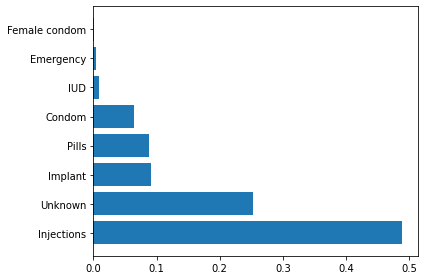

In [515]:
fig, ax = plt.subplots(1)

ax.barh(x, y)
plt.xticks(rotation='horizontal')
plt.tight_layout()
fig.savefig('figures/' + ctry + '-methods.pdf')

### collate the covariate data and outcome/treatment data

In [84]:
series_list = []

for idx, row in treatment_outcome_df.iteritems():
    l = list(filtered_data.loc[idx])
    t = row[0]
    o = row[1]
    
    l = l + [t, o]
    series_list.append(pd.Series(l, name=idx))

In [85]:
cols = list(filtered_data.columns) + ['treatment', 'outcome']
df = pd.DataFrame(series_list)
df.columns = cols
df.head(2)

,v101,v102,v104,v106,v107,v113,v115,v116,v119,v120,...,v626,v627,v628,v629,v012,v384a,v384b,v384c,treatment,outcome
8194,1.0,1.0,13.0,2.0,2.0,14.0,5.0,23.0,0.0,0.0,...,4.0,1.0,2.0,0.0,32.0,0.0,1.0,0.0,1.0,0.0
2,3.0,2.0,95.0,1.0,7.0,21.0,40.0,31.0,0.0,0.0,...,5.0,2.0,2.0,0.0,28.0,0.0,0.0,0.0,1.0,1.0


In [86]:
tmean, omean = df['treatment'].mean(), df['outcome'].mean()
censored_tmean = df[df['outcome'].isna()]['treatment'].mean()
sz = len(df)
sz_uncensored  = len(df[~df['outcome'].isna()])

outcome_group = df[['treatment', 'outcome']].groupby(['treatment']).mean()
outcome_group_0 = outcome_group.loc[0].outcome
outcome_group_1 = outcome_group.loc[1].outcome

In [87]:
with open('datastats.txt', 'a+') as fp:
    
    fp.write(ctry + '\n')
    fp.write(str(tmean) + "," + str(omean) + '\n')
    fp.write(str(censored_tmean)  + '\n')
    fp.write(str(sz)  + "," + str(sz_uncensored)  + '\n')
    fp.write(str(outcome_group_0)  + "," + str(outcome_group_1)  + '\n')

In [88]:
df.to_csv('data/' + ctry.upper() + '_Preprocessed.csv', index=False)

### Uganda:

T=1,0.6984973339796413   
O=1,0.2525448376151236    
N=4126   


### Mali:

T=1,0.39526276831976315   
O=1,0.1073279052553664    
N=1351   



### Liberia:

T=1,0.67138671875    
O=1,0.197265625    
N=2048   


### Guinea:

T=1,0.2556497175141243       
O=1,0.3177966101694915    
N=708   


### Gambia:

T=1,0.5262135922330097    
O=1,0.14692556634304207   
N=1545  


### Burundi:

T=1,0.5992524916943521   
O=1,0.2084717607973422  
N=2408

### Senegal:

T=1,0.45182972367438384  
O=1,0.10082150858849888  
N=1339

### South Africa
T=1,0.6669266770670826  
O=1,0.1060842433697348  
N=1282

### Benin
T=1,0.2437937619350732  
O=0.09548058561425843  
N=1571

### Zambia
T=1,0.6534862662239662  
O=0.16480531240567461  
N=3313

### Sierra Leone
T=1,0.44719642242862057  
O=0.14516683866529068  
N=2907

### Power analysis

In [176]:
df = pd.read_csv('data/ET_2016_Preprocessed.csv')

In [202]:
X = df[~df['outcome'].isna()]

In [203]:
from statsmodels.stats.power import TTestIndPower
from statistics import mean, stdev
from math import sqrt

c0 = X[X['treatment'] == 0]['outcome'].values
c1 = X[X['treatment'] == 1]['outcome'].values

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
cohens_d

p = X['treatment'].mean()
random_a = pd.Series(np.random.binomial(1, p, size=X.shape[0]))

AD = X[X['treatment'] == 1]['outcome'].mean() - (X['outcome'].iloc[random_a[random_a == 1].index]).mean()
POB = 0.5 * (AD + 1)

In [101]:
cohens_d_r = np.arange(0.05, 0.25, 0.05)

In [102]:
results = []
for cohens_d in cohens_d_r:
    effect = cohens_d
    alpha = 0.01
    power = 0.9

    analysis = TTestIndPower()
    result = analysis.solve_power(effect, power=power, nobs1=None, ratio=len(c1)/len(c0), alpha=alpha)
    # print('Sample Size: %.3f' % result)
    results.append(result)

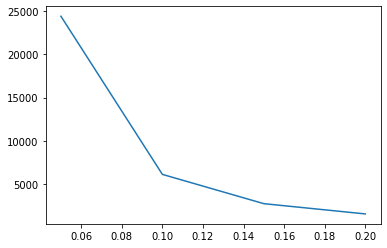

In [104]:
plt.plot(cohens_d_r, results)

In [204]:
effect = POB
alpha = 0.01
power = 0.9

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=len(c1)/len(c0), alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 123.167
